# Introduction

In this notebook we'll use PyCaret to create and save a model. In the next notebook we'll deploy the model by creating a simple web app.

# Get the data

In [1]:
from pycaret.datasets import get_data

Here's a list of the data in the PyCaret repository. Remember that you could of course load the data from a CSV file or similar. 

In [2]:
#_ = get_data()

Let's select the `bike` data set. It's a bike-sharing data set where the goal is to predict the number of bike rentals given a set of features. See here for a description: https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset. 

In [3]:
df = get_data('bike')

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,1/1/2011,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,16
1,2,1/1/2011,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,40
2,3,1/1/2011,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,32
3,4,1/1/2011,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,13
4,5,1/1/2011,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     17379 non-null  int64  
 1   dteday      17379 non-null  object 
 2   season      17379 non-null  int64  
 3   yr          17379 non-null  int64  
 4   mnth        17379 non-null  int64  
 5   hr          17379 non-null  int64  
 6   holiday     17379 non-null  int64  
 7   weekday     17379 non-null  int64  
 8   workingday  17379 non-null  int64  
 9   weathersit  17379 non-null  int64  
 10  temp        17379 non-null  float64
 11  atemp       17379 non-null  float64
 12  hum         17379 non-null  float64
 13  windspeed   17379 non-null  float64
 14  cnt         17379 non-null  int64  
dtypes: float64(4), int64(10), object(1)
memory usage: 2.0+ MB


Here's a description of the features, copied from https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset. 

```
- instant: record index
- dteday : date
- season : season (1:winter, 2:spring, 3:summer, 4:fall)
- yr : year (0: 2011, 1:2012)
- mnth : month ( 1 to 12)
- hr : hour (0 to 23)
- holiday : weather day is holiday or not (extracted from [Web Link])
- weekday : day of the week
- workingday : if day is neither weekend nor holiday is 1, otherwise is 0.
+ weathersit :
- 1: Clear, Few clouds, Partly cloudy, Partly cloudy
- 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
- 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
- 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog
- temp : Normalized temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-8, t_max=+39 (only in hourly scale)
- atemp: Normalized feeling temperature in Celsius. The values are derived via (t-t_min)/(t_max-t_min), t_min=-16, t_max=+50 (only in hourly scale)
- hum: Normalized humidity. The values are divided to 100 (max)
- windspeed: Normalized wind speed. The values are divided to 67 (max)
- casual: count of casual users
- registered: count of registered users
- cnt: count of total rental bikes including both casual and registered 
```

What's the distribution of bike rental counts?

<AxesSubplot:>

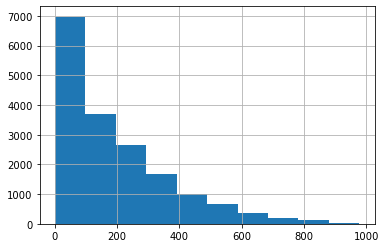

In [5]:
df.cnt.hist()

# Prepare data

We use PyCaret to automatically prepare the data for us (using the default settings of the `setup` function):

In [6]:
from pycaret.regression import *

In [7]:
clf = setup(df, target = 'cnt', ignore_features=['instant'])

,Description,Value
0,session_id,8002
1,Target,cnt
2,Original Data,"(17379, 15)"
3,Missing Values,False
4,Numeric Features,5
5,Categorical Features,7
6,Ordinal Features,False
7,High Cardinality Features,False
8,High Cardinality Method,None
9,Transformed Train Set,"(12165, 37)"


# Modelling

Let's find the top performing models from those in PyCaret:

In [8]:
top5 = compare_models(n_select=5, sort='R2')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
catboost,CatBoost Regressor,25.4058,1612.0208,40.1008,0.9508,0.4393,0.4443,0.3810
xgboost,Extreme Gradient Boosting,26.7526,1787.3949,42.2259,0.9455,0.4447,0.4385,0.1630
et,Extra Trees Regressor,26.0537,1831.1566,42.7049,0.9442,0.3425,0.3171,0.2110
lightgbm,Light Gradient Boosting Machine,27.0746,1849.5644,42.9545,0.9436,0.4229,0.4273,0.0280
rf,Random Forest Regressor,26.7028,1937.6419,43.9843,0.9410,0.3484,0.3235,0.2000
dt,Decision Tree Regressor,36.4978,3852.7494,61.9736,0.8829,0.4565,0.4002,0.0200
knn,K Neighbors Regressor,42.6080,4491.5115,66.9691,0.8634,0.4447,0.4778,0.0310
gbr,Gradient Boosting Regressor,49.5635,5291.0658,72.7165,0.8394,0.7039,1.0081,0.1020
ada,AdaBoost Regressor,87.8716,11616.4779,107.7360,0.6462,1.0842,2.8419,0.0760
br,Bayesian Ridge,105.2288,19826.0612,140.7531,0.3989,1.2040,3.3351,0.0160


The natural next step would be to tune the top models (i.e. hyperparameter-tuning using grid search or random search). We skip this as it takes quite some time. 

In [9]:
#tuned_top5 = [tune_model(i) for i in top5]

Let's create bagging ensembles for all our top 5 models:

In [10]:
bagged_top5 = [ensemble_model(i) for i in top5]

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,28.7020,2102.6269,45.8544,0.9361,0.3365,0.3298
1,27.8311,1952.9483,44.1922,0.9417,0.3575,0.3283
2,27.2821,2024.3975,44.9933,0.9287,0.3479,0.3301
3,26.9496,1789.3700,42.3009,0.9513,0.3798,0.3672
4,28.2652,2076.7187,45.5710,0.9408,0.3769,0.3972
5,29.0071,2145.9664,46.3246,0.9350,0.3702,0.3555
6,28.1665,2112.4694,45.9616,0.9387,0.3494,0.3206
7,28.2519,2191.1045,46.8092,0.9334,0.3481,0.3101
8,26.7870,1742.3751,41.7418,0.9487,0.3632,0.3524
9,28.3572,2018.7321,44.9303,0.9317,0.3874,0.3744


We can also try to blend the models (i.e., have them vote using a `VotingRegressor`):

In [11]:
blender = blend_models(estimator_list = top5)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,24.9445,1654.4372,40.6748,0.9498,0.3329,0.2961
1,23.6231,1482.7093,38.5060,0.9557,0.3487,0.3096
2,24.1051,1640.2771,40.5003,0.9422,0.3531,0.3387
3,22.3618,1265.2419,35.5702,0.9656,0.3518,0.3305
4,24.4278,1622.9167,40.2854,0.9537,0.3595,0.3547
5,24.3138,1572.2252,39.6513,0.9524,0.3571,0.3293
6,24.2381,1535.6864,39.1878,0.9555,0.3506,0.3163
7,24.4033,1800.4810,42.4321,0.9452,0.3314,0.2837
8,22.9789,1258.2064,35.4712,0.9630,0.3570,0.3330
9,23.6345,1508.1850,38.8354,0.9490,0.3381,0.3027


...or stack them (i.e., train a model to figure out how to blend the models):

In [12]:
stacked = stack_models(estimator_list = top5)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,24.6164,1573.6496,39.6693,0.9522,0.3701,0.3210
1,23.4735,1436.2826,37.8983,0.9571,0.4127,0.3422
2,24.3133,1606.1938,40.0773,0.9434,0.4120,0.3816
3,21.7945,1171.8022,34.2316,0.9681,0.4071,0.3688
4,24.1031,1572.2421,39.6515,0.9552,0.4056,0.4008
5,24.0286,1508.9949,38.8458,0.9543,0.4221,0.3681
6,23.5935,1462.9499,38.2485,0.9576,0.3781,0.3316
7,24.3362,1776.8851,42.1531,0.9460,0.3947,0.3007
8,22.7041,1222.3413,34.9620,0.9640,0.4107,0.3630
9,23.5239,1496.6732,38.6869,0.9494,0.3827,0.3169


Now we've trained a bunch of models (all the individual models + the ensemble + the blended models). Instead of sorting through all the models to pick what's best we can let PyCaret do it for us using the `automl` function:

In [13]:
best = automl(optimize='R2')

Here's the best model we found in the above process:

In [14]:
best

StackingRegressor(cv=KFold(n_splits=10, random_state=RandomState(MT19937) at 0x258DA1C8840,
   shuffle=False),
                  estimators=[('catboost',
                               <catboost.core.CatBoostRegressor object at 0x00000258D92B3D90>),
                              ('xgboost',
                               XGBRegressor(base_score=0.5, booster='gbtree',
                                            colsample_bylevel=1,
                                            colsample_bynode=1,
                                            colsample_bytree=1,
                                            enable_categorical=False, gamma=0,
                                            gpu_id=-1, impor...
                                                     max_samples=None,
                                                     min_impurity_decrease=0.0,
                                                     min_impurity_split=None,
                                                     min_samples_

# Evaluate models

Let's compute predictions and scores on the test data using the best model found above:

In [15]:
preds = predict_model(best)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Stacking Regressor,22.7138,1370.3556,37.0183,0.9578,0.4051,0.3518


In [16]:
preds.columns

Index(['hr', 'temp', 'atemp', 'hum', 'windspeed', 'season_1', 'season_2',
       'season_3', 'season_4', 'yr_1', 'mnth_10', 'mnth_11', 'mnth_3',
       'mnth_5', 'mnth_7', 'mnth_8', 'mnth_9', 'holiday_0', 'weekday_1',
       'weekday_4', 'weekday_5', 'workingday_1', 'weathersit_1',
       'weathersit_2', 'weathersit_3', 'weathersit_4', 'dteday_month_1',
       'dteday_month_12', 'dteday_month_2', 'dteday_month_4', 'dteday_month_6',
       'dteday_weekday_1', 'dteday_weekday_2', 'dteday_weekday_5',
       'dteday_weekday_6', 'dteday_is_month_end_0', 'dteday_is_month_start_0',
       'cnt', 'Label'],
      dtype='object')

In [17]:
preds.cnt.values

array([568, 353, 281, ..., 463, 360,   6], dtype=int64)

In [18]:
preds.Label

0       553.809694
1       318.275549
2       267.693497
3        38.683506
4         5.018970
           ...    
5209    189.428280
5210     41.288023
5211    437.996189
5212    357.037902
5213      8.866153
Name: Label, Length: 5214, dtype: float64

Looks good. As always, one should take a closer look at the predictions and the features used by the model

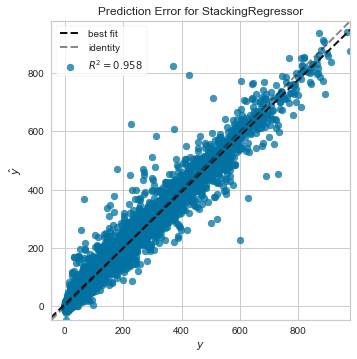

In [19]:
plot_model(best, 'error')

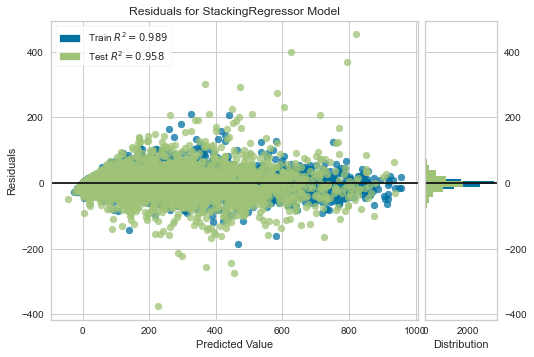

In [20]:
plot_model(best)

A useful technique we haven't talked about yet is to plot so-called "learning curves": a plot of the performance versus the amount of training data given to the model. Among other things, such plots can indicate whether having more data (of the same kind) would increase performance, and provide an estimate of how much it would increase.

This takes some time to compute so I've attached the output as an image below.

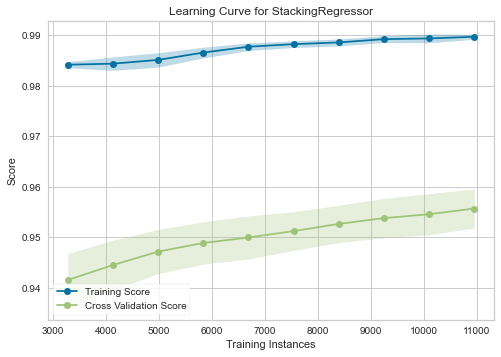

In [21]:
plot_model(best, 'learning')

Learning curve: 

<img width=40% src="assets/learningcurves.png">

A way to get data-driven feature importances is to compute "permutation importance". Essentially: rank the features by observing the performance effects of random permutations of the entries in each feature column (separately). This is implemented in scikit-learn's `permutation_importance`.

In [21]:
from sklearn.inspection import permutation_importance

In [22]:
X_test = get_config(variable='X_test')
y_test = get_config(variable='y_test')

In [23]:
r = permutation_importance(best, X_test, y_test)

Here's the ranked list:

In [24]:
for i in r.importances_mean.argsort()[::-1]:
    if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
        print(f"{X_test.columns[i]:<8}"
        f"{r.importances_mean[i]:.3f}"
        f" +/- {r.importances_std[i]:.3f}")

hr      1.398 +/- 0.018
workingday_10.288 +/- 0.005
yr_1    0.187 +/- 0.005
temp    0.076 +/- 0.002
hum     0.031 +/- 0.002
season_10.028 +/- 0.001
atemp   0.022 +/- 0.001
weathersit_30.014 +/- 0.001
weekday_50.008 +/- 0.000
season_40.006 +/- 0.000
weathersit_10.004 +/- 0.000
dteday_weekday_50.004 +/- 0.000
windspeed0.003 +/- 0.000
dteday_weekday_60.003 +/- 0.000
holiday_00.002 +/- 0.000
dteday_month_120.002 +/- 0.000
mnth_9  0.002 +/- 0.000
weekday_40.002 +/- 0.000
dteday_month_40.002 +/- 0.000
weekday_10.002 +/- 0.000
mnth_3  0.001 +/- 0.000
mnth_5  0.001 +/- 0.000
dteday_month_10.001 +/- 0.000
mnth_11 0.001 +/- 0.000
mnth_10 0.001 +/- 0.000
dteday_is_month_start_00.001 +/- 0.000
dteday_month_60.001 +/- 0.000
season_20.001 +/- 0.000
dteday_weekday_20.001 +/- 0.000
mnth_8  0.001 +/- 0.000
weathersit_20.001 +/- 0.000
dteday_month_20.000 +/- 0.000
mnth_7  0.000 +/- 0.000
dteday_weekday_10.000 +/- 0.000
dteday_is_month_end_00.000 +/- 0.000
season_30.000 +/- 0.000


> That the `hr` is ranked high seems reasonable. That a year (`yr`) feature is ranked high should give us pause. If the model is supposed to be used to forecast demand we should've treated this as a time-series problem: trained the model on historical data and evaluated it on future data. However, as we don't know all the details about the situation generating the data, f.ex. whether the total number of bikes changed from year-to-year or whether there were efforts to recruit additional bike sharers, we can't really provide a very careful and comprehensive treatment of the problem.

# Export pre-processing pipeline and model

Let's save the model for deployment in the next notebook:

First we finalize the model (meaning we use the test data as well for training the model [no reason to waste labelled data]):

In [25]:
final_model = finalize_model(best)

In [26]:
save_model(final_model, 'saved_model_161121')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=[],
                                       display_types=True,
                                       features_todrop=['instant'],
                                       id_columns=['instant'],
                                       ml_usecase='regression',
                                       numerical_features=[], target='cnt',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_available',
                                 fill_value_categorical=None,
                                 fill_value_numerical=None,
                                 nu...
                                                                       min_impurity_decrease=0.0,
                                                                       min_impurity_split=None,
                                         